In [280]:
import pandas as pd
import numpy as np
import random
%matplotlib inline
import matplotlib.pyplot as plt
import surprise
from surprise import SVD, SVDpp, NMF
from surprise import Dataset
from surprise import Reader
from surprise import evaluate, print_perf
from surprise import KNNBasic
from surprise import AlgoBase, BaselineOnly
from get_top_n import get_top_n
from surprise.accuracy import rmse, mae

# Model based

In [281]:
#Load data
dt = pd.read_csv('sample_data.csv',index_col=0)
dt.head()

,reviewerID,productID,rating,date
370183,A2OR4QUQSUMOW7,B0016B9FSU,4.0,2013-01-31
370186,A14E7LZASLSX36,B0016B9FSU,5.0,2013-03-21
370189,A9ESHA5MS6S6L,B0016B9FSU,5.0,2013-01-17
370192,ATATZGNDHA5ZD,B0016B9FSU,5.0,2013-02-05
370193,AN4HRAGRHHX1H,B0016B9FSU,5.0,2013-01-03


In [282]:
#Construct missing ratings we need to predict
select_data = dt.pivot_table('rating',index=['reviewerID','productID'],dropna=False)
select_data = select_data.loc[select_data['rating'].isnull()]
select_data.reset_index(inplace=True)
missing_values = select_data[['reviewerID','productID']].values

In [283]:
reader = Reader(rating_scale=(1,5))
dt = Dataset.load_from_df(dt[['reviewerID','productID','rating']],reader)

In [284]:
raw_ratings = dt.raw_ratings
#Shuffle ratings
random.seed(42)
random.shuffle(raw_ratings)
#Split to training and test sets
threshold = int(.8 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]

In [285]:
dt.raw_ratings = A_raw_ratings  # dt is now the set A - training set
dt.split(n_folds=3)

In [286]:
#Baseline model: User's bias & item's bias
class BaselineModel(AlgoBase):

    def __init__(self):
        AlgoBase.__init__(self)

    def compute_bias(self):
        bu = np.zeros(self.trainset.n_users)
        bi = np.zeros(self.trainset.n_items)
        global_mean = self.trainset.global_mean
        
        for i in self.trainset.all_items():
            dev_i = 0
            for (u, r) in self.trainset.ir[i]:
                dev_i += r - global_mean
            bi[i] = dev_i/(len(self.trainset.ir[i]))
        
        for u in self.trainset.all_users():
            dev_u = 0
            for (i, r) in self.trainset.ur[u]:
                dev_u += r - global_mean
            bu[u] = dev_u/(len(self.trainset.ur[u]))
        return bu, bi
    
    def train(self, trainset):
        AlgoBase.train(self, trainset)
        self.bu, self.bi = self.compute_bias()

    def estimate(self, u, i):
        est = self.trainset.global_mean
        if self.trainset.knows_user(u):
            est += self.bu[u]
        if self.trainset.knows_item(i):
            est += self.bi[i]
        return est

algo1 = BaselineModel()

In [287]:
#Construct train set and test set for use by surprise
trainset = dt.build_full_trainset()
testset = dt.construct_testset(B_raw_ratings)  # testset is now the set B

In [288]:
#Train and predict using baseline model
algo1.train(trainset)
baseline_predictions = algo1.test(testset)

In [289]:
#Accuracy on test set
rmse(baseline_predictions)
mae(baseline_predictions)

RMSE: 1.0607
MAE:  0.7961


0.79607315037876514

In [290]:
#SVD
algo2 = SVD()
algo2.train(trainset)
svd_predictions = algo2.test(testset)
rmse(svd_predictions)
mae(svd_predictions)

RMSE: 0.9615
MAE:  0.7501


0.75010621530949217

# Metrics

In [291]:
#Function to calculate coverage ratio
def coverage_ratio(predictions, n):
    top_n = get_top_n(predictions, n)
    product_list = []
    recommended_list = []
    for uid, iid, true_r, est, _ in predictions:
        product_list.append(iid)
    for uid, user_ratings in top_n.items():
        recommended_list.append(user_ratings[0][0])
    coverage = float(len(set(recommended_list))) / float(len(set(product_list)))
    return coverage

In [292]:
coverage_ratio(svd_predictions,1)

0.9571428571428572

In [293]:
#Function to predict missing values based on an algorithm
def mv_prediction(algo,missing_values):
    predictions = [algo.predict(uid, iid)
                       for (uid, iid) in missing_values]
    return predictions

In [294]:
mv_prediction_list = mv_prediction(algo2,missing_values)

In [295]:
coverage_ratio(mv_prediction_list,7)

0.22857142857142856

# KNN

## use a default knn config

In [296]:
## define algorithm config
algo_name = KNNBasic ##  KNNWithMeans,KNNBaseline
sim_option={'name': 'pearson', ## cosine, msd, pearson, personbaseline
                 'user_based': 'False', ## False for item-based
                 'min_surpport':0 }##  if |Iuv|<min_support then sim(u,v)=0
max_k = 40 ## The (max) number of neighbors to take into account for aggregation
min_k = 1 ##  If there are not enough neighbors, the prediction is set the the global mean of all ratings

In [297]:
knn_default = algo_name(k = max_k, min_k = min_k, sim_options=sim_option)

In [298]:
knn_default.train(trainset)
defaultknn_prediction=knn_default.test(testset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


### accuracy

In [299]:
# the accuracy of the tainset
perf = evaluate(knn_default, dt, measures=['RMSE','MAE'], verbose= 1)

Evaluating RMSE, MAE of algorithm KNNBasic.

------------
Fold 1
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0581
MAE:  0.8099
------------
Fold 2
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0534
MAE:  0.8001
------------
Fold 3
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0314
MAE:  0.7969
------------
------------
Mean RMSE: 1.0476
Mean MAE : 0.8023
------------
------------


In [300]:
#Accuracy on test set
rmse(defaultknn_prediction)
mae(defaultknn_prediction)

RMSE: 1.0367
MAE:  0.8065


0.80654070564642

### coverage

In [301]:
coverage_ratio(defaultknn_prediction,1)

0.9714285714285714

In [302]:
mv_knnprediction = mv_prediction(knn_default,missing_values)
coverage_ratio(mv_knnprediction,7)

0.45714285714285713

### changing hyper-paramater

In [303]:
algo_name = KNNBasic
#Define the different hyper-paramter range
grid_param = {'k':[20,30,40,50,60],
             'min_k':[1,5,10],
             'sim_options':{'name':['msd','cosine','pearson'],
                           'min_surpport':[0,3,5],
                           'user_based':[False]}
             }

In [304]:
grid_search = surprise.GridSearch(algo_name, grid_param, measures=['RMSE', 'MAE'],verbose = 1)
grid_search.evaluate(dt)

[{'k': 20, 'min_k': 1, 'sim_options': {'name': 'msd', 'min_surpport': 0, 'user_based': False}}, {'k': 20, 'min_k': 1, 'sim_options': {'name': 'msd', 'min_surpport': 3, 'user_based': False}}, {'k': 20, 'min_k': 1, 'sim_options': {'name': 'msd', 'min_surpport': 5, 'user_based': False}}, {'k': 20, 'min_k': 1, 'sim_options': {'name': 'cosine', 'min_surpport': 0, 'user_based': False}}, {'k': 20, 'min_k': 1, 'sim_options': {'name': 'cosine', 'min_surpport': 3, 'user_based': False}}, {'k': 20, 'min_k': 1, 'sim_options': {'name': 'cosine', 'min_surpport': 5, 'user_based': False}}, {'k': 20, 'min_k': 1, 'sim_options': {'name': 'pearson', 'min_surpport': 0, 'user_based': False}}, {'k': 20, 'min_k': 1, 'sim_options': {'name': 'pearson', 'min_surpport': 3, 'user_based': False}}, {'k': 20, 'min_k': 1, 'sim_options': {'name': 'pearson', 'min_surpport': 5, 'user_based': False}}, {'k': 20, 'min_k': 5, 'sim_options': {'name': 'msd', 'min_surpport': 0, 'user_based': False}}, {'k': 20, 'min_k': 5, 'sim_o

Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.1267
Mean MAE : 0.8489
------------
------------
Parameters combination 3 of 135
params:  {'k': 20, 'min_k': 1, 'sim_options': {'name': 'msd', 'min_surpport': 5, 'user_based': False}}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.1267
Mean MAE : 0.8489
------------
------------
Parameters combination 4 of 135
params:  {'k': 20, 'min_k': 1, 'sim_options': {'name': 'cosine', 'min_surpport': 0, 'user_based': False}}
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.1399
Mean MAE : 0.8637
--------

Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0312
Mean MAE : 0.7961
------------
------------
Parameters combination 22 of 135
params:  {'k': 20, 'min_k': 10, 'sim_options': {'name': 'cosine', 'min_surpport': 0, 'user_based': False}}
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0414
Mean MAE : 0.8056
------------
------------
Parameters combination 23 of 135
params:  {'k': 20, 'min_k': 10, 'sim_options': {'name': 'cosine', 'min_surpport': 3, 'user_based': False}}
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
-------

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0452
Mean MAE : 0.8153
------------
------------
Parameters combination 41 of 135
params:  {'k': 30, 'min_k': 5, 'sim_options': {'name': 'cosine', 'min_surpport': 3, 'user_based': False}}
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0452
Mean MAE : 0.8153
------------
------------
Parameters combination 42 of 135
params:  {'k': 30, 'min_k': 5, 'sim_options': {'name': 'cosine', 'min_surpport': 5, 'user_based': False}}
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix..

Mean MAE : 0.8760
------------
------------
Parameters combination 62 of 135
params:  {'k': 40, 'min_k': 1, 'sim_options': {'name': 'pearson', 'min_surpport': 3, 'user_based': False}}
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.1609
Mean MAE : 0.8760
------------
------------
Parameters combination 63 of 135
params:  {'k': 40, 'min_k': 1, 'sim_options': {'name': 'pearson', 'min_surpport': 5, 'user_based': False}}
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.1609
Mean MAE : 0.8760
------------
------------
Parameters combination 64 of 135
params:  {'k': 40, 'min_k': 5, 

params:  {'k': 50, 'min_k': 1, 'sim_options': {'name': 'msd', 'min_surpport': 0, 'user_based': False}}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.1284
Mean MAE : 0.8507
------------
------------
Parameters combination 83 of 135
params:  {'k': 50, 'min_k': 1, 'sim_options': {'name': 'msd', 'min_surpport': 3, 'user_based': False}}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.1284
Mean MAE : 0.8507
------------
------------
Parameters combination 84 of 135
params:  {'k': 50, 'min_k': 1, 'sim_options': {'name': 'msd', 'min_surpport': 5, 'user_based': False}}
Computing the msd similarity matrix..

Mean RMSE: 1.0331
Mean MAE : 0.7979
------------
------------
Parameters combination 103 of 135
params:  {'k': 50, 'min_k': 10, 'sim_options': {'name': 'cosine', 'min_surpport': 0, 'user_based': False}}
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0423
Mean MAE : 0.8069
------------
------------
Parameters combination 104 of 135
params:  {'k': 50, 'min_k': 10, 'sim_options': {'name': 'cosine', 'min_surpport': 3, 'user_based': False}}
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0423
Mean MAE : 0.8069
------------
------------
Parameters combination 105 of 135
params:  {'k': 5

params:  {'k': 60, 'min_k': 5, 'sim_options': {'name': 'cosine', 'min_surpport': 3, 'user_based': False}}
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0455
Mean MAE : 0.8155
------------
------------
Parameters combination 123 of 135
params:  {'k': 60, 'min_k': 5, 'sim_options': {'name': 'cosine', 'min_surpport': 5, 'user_based': False}}
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0455
Mean MAE : 0.8155
------------
------------
Parameters combination 124 of 135
params:  {'k': 60, 'min_k': 5, 'sim_options': {'name': 'pearson', 'min_surpport': 0, 'user_based': False}}
Computi

In [305]:
grid_search.best_params['RMSE']

{'k': 20,
 'min_k': 10,
 'sim_options': {'min_surpport': 0, 'name': 'msd', 'user_based': False}}

In [306]:
grid_search.best_score['RMSE']

1.0312498977533373

In [307]:
grid_search.best_params['MAE']

{'k': 20,
 'min_k': 10,
 'sim_options': {'min_surpport': 0, 'name': 'msd', 'user_based': False}}

In [308]:
grid_search.best_score['MAE']

0.79610249533468036

In [309]:
### get the result of different hyper-parameter

In [331]:
#
results_df = pd.DataFrame.from_dict(grid_search.cv_results)
plotdata = results_df.loc[:,['MAE','RMSE','k','min_k']]
name_list = []
min_surppot_list = []
for param in results_df.params:
#     print(param)
    name_list.append(param['sim_options']['name'])
    min_surppot_list.append(param['sim_options']['min_surpport'])
    
name_list = pd.Series(name_list)
min_surppot_list = pd.Series(min_surppot_list)

plotdata['sim_matric'] = name_list
plotdata['min_support'] = min_surppot_list
plotdata.head()

,MAE,RMSE,k,min_k,sim_matric,min_support
0,0.848934,1.126651,20,1,msd,0
1,0.848934,1.126651,20,1,msd,3
2,0.848934,1.126651,20,1,msd,5
3,0.863714,1.139934,20,1,cosine,0
4,0.863714,1.139934,20,1,cosine,3
5,0.863714,1.139934,20,1,cosine,5
6,0.875966,1.160948,20,1,pearson,0
7,0.875966,1.160948,20,1,pearson,3
8,0.875966,1.160948,20,1,pearson,5
9,0.801548,1.031275,20,5,msd,0


In [322]:
plotdata_max_k = plotdata[plotdata.min_k <2]
plotdata_max_k = plotdata_max_k[plotdata_max_k.min_support == 3]
plotdata_max_k = plotdata_max_k[plotdata_max_k.sim_matric == 'pearson']
plotdata_max_k

,MAE,RMSE,k,min_k,sim_matric,min_support
7,0.875966,1.160948,20,1,pearson,3
34,0.875957,1.160948,30,1,pearson,3
61,0.875957,1.160948,40,1,pearson,3
88,0.875957,1.160948,50,1,pearson,3
115,0.875957,1.160948,60,1,pearson,3


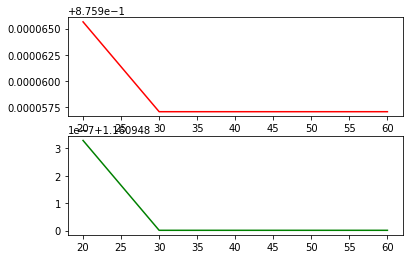

In [328]:
plt.subplot(2, 1, 1) 
plt.plot(plotdata_max_k.k, plotdata_max_k.MAE, 'r')
plt.subplot(2, 1, 2)
plt.plot(plotdata_max_k.k, plotdata_max_k.RMSE, 'g')
plt.show()

In [318]:
plotdata_mink = plotdata[plotdata.sim_matric =='cosine']
plotdata_mink = plotdata_mink[plotdata_mink.min_support == 3]
plotdata_mink = plotdata_mink[plotdata_mink.k == 40]
plotdata_mink

,MAE,RMSE,k,min_k,sim_matric,min_support
58,0.864973,1.140749,40,1,cosine,3
67,0.815545,1.045538,40,5,cosine,3
76,0.806868,1.042273,40,10,cosine,3


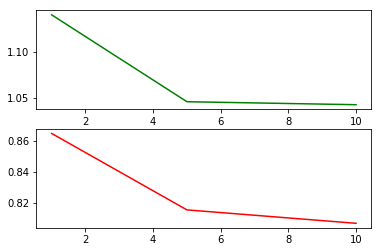

In [321]:
plt.subplot(2, 1, 2) 
plt.plot(plotdata_mink.min_k, plotdata_mink.MAE, 'r')
plt.subplot(2, 1, 1)
plt.plot(plotdata_mink.min_k, plotdata_mink.RMSE, 'g')
plt.show()

In [333]:
plotdata_sim = plotdata[plotdata.min_k ==1]
plotdata_sim = plotdata_sim[plotdata_sim.min_support == 0]
plotdata_sim = plotdata_sim[plotdata_sim.k == 40]
plotdata_sim

,MAE,RMSE,k,min_k,sim_matric,min_support
54,0.850682,1.128388,40,1,msd,0
57,0.864973,1.140749,40,1,cosine,0
60,0.875957,1.160948,40,1,pearson,0


In [335]:
plotdata_sim.loc['sim_matric','MAE','RMSE']

KeyError: 'the label [sim_matric] is not in the [index]'